# Bibliotecas

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import lit,collect_list, sum as sum_, col, regexp_replace,concat_ws
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql.types import IntegerType

from pyspark.ml.clustering import KMeans

from pyspark.ml.feature import VectorAssembler
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import unidecode
import re
import os

import statsmodels.api as sm
import pmdarima as pm

import pyarrow as pa
import pyarrow.csv as pc

import tensorflow as tf
from tensorflow.keras import layers, models

from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator

# Iniciar Builders

In [2]:
# Iniciar uma sessão Spark
spark = SparkSession.builder \
    .appName("Viagens") \
    .getOrCreate()


# Carregar os arquivos CSV


In [3]:
def normalize_column_name(col_name):    
    col_name = unidecode.unidecode(col_name)
    col_name = col_name.replace(" ", "_")   
    col_name = col_name.replace(":", "")    
    col_name = re.sub(r"_$", "", col_name)
    return col_name

# Função para ler arquivos e adicionar a coluna ano
def ler_csv_com_ano(caminho, ano):
    df = spark.read.csv(caminho, sep=';', header=True, inferSchema=True, encoding='ISO-8859-1')
    for col_name in df.columns:
        df = df.withColumnRenamed(col_name, normalize_column_name(col_name))
    return df.withColumn("ano", lit(ano))

# Lendo arquivos de 2022 e adicionando a coluna ano
df_Pagamentos_22 = ler_csv_com_ano("../ARQUIVOS/2022_20240804_Viagens/2022_Pagamento.csv", 2022)
df_Passagem_22 = ler_csv_com_ano("../ARQUIVOS/2022_20240804_Viagens/2022_Passagem.csv", 2022)
df_Trecho_22 = ler_csv_com_ano("../ARQUIVOS/2022_20240804_Viagens/2022_Trecho.csv", 2022)
df_Viagem_22 = ler_csv_com_ano("../ARQUIVOS/2022_20240804_Viagens/2022_Viagem.csv", 2022)

# Lendo arquivos de 2023 e adicionando a coluna ano
df_Pagamentos_23 = ler_csv_com_ano("../ARQUIVOS/2023_20240804_Viagens/2023_Pagamento.csv", 2023)
df_Passagem_23 = ler_csv_com_ano("../ARQUIVOS/2023_20240804_Viagens/2023_Passagem.csv", 2023)
df_Trecho_23 = ler_csv_com_ano("../ARQUIVOS/2023_20240804_Viagens/2023_Trecho.csv", 2023)
df_Viagem_23 = ler_csv_com_ano("../ARQUIVOS/2023_20240804_Viagens/2023_Viagem.csv", 2023)

# Lendo arquivos de 2024 e adicionando a coluna ano
df_Pagamentos_24 = ler_csv_com_ano("../ARQUIVOS/2024_20240804_Viagens/2024_Pagamento.csv", 2024)
df_Passagem_24 = ler_csv_com_ano("../ARQUIVOS/2024_20240804_Viagens/2024_Passagem.csv", 2024)
df_Trecho_24 = ler_csv_com_ano("../ARQUIVOS/2024_20240804_Viagens/2024_Trecho.csv", 2024)
df_Viagem_24 = ler_csv_com_ano("../ARQUIVOS/2024_20240804_Viagens/2024_Viagem.csv", 2024)

# Unindo os DataFrames de cada tipo
df_Pagamentos = df_Pagamentos_22.unionByName(df_Pagamentos_23).unionByName(df_Pagamentos_24)
df_Passagem = df_Passagem_22.unionByName(df_Passagem_23).unionByName(df_Passagem_24)
df_Trecho = df_Trecho_22.unionByName(df_Trecho_23).unionByName(df_Trecho_24)
df_Viagem = df_Viagem_22.unionByName(df_Viagem_23).unionByName(df_Viagem_24)

In [4]:
'''df_Pagamentos.printSchema()
df_Passagem.printSchema()
df_Trecho.printSchema()
df_Viagem.printSchema()
df_Viagem.printSchema()'''

#df_Viagem.filter(col("Identificador_do_processo_de_viagem") == 18781059).show()




'df_Pagamentos.printSchema()\ndf_Passagem.printSchema()\ndf_Trecho.printSchema()\ndf_Viagem.printSchema()\ndf_Viagem.printSchema()'

# Agrupar Viagem

In [5]:
# Converter as colunas de valor de string para float, substituindo vírgulas por pontos
df_Viagem = df_Viagem.withColumn("Valor_diarias", regexp_replace(col("Valor_diarias"), ",", ".").cast("float"))
df_Viagem = df_Viagem.withColumn("Valor_passagens", regexp_replace(col("Valor_passagens"), ",", ".").cast("float"))
df_Viagem = df_Viagem.withColumn("Valor_devolucao", regexp_replace(col("Valor_devolucao"), ",", ".").cast("float"))
df_Viagem = df_Viagem.withColumn("Valor_outros_gastos", regexp_replace(col("Valor_outros_gastos"), ",", ".").cast("float"))

# Agrupar e agregar os dados conforme necessário
df_Viagem = df_Viagem.groupBy(
    'Identificador_do_processo_de_viagem',
    'Numero_da_Proposta_(PCDP)',
    'ano'
).agg(
    F.concat_ws(", ", F.collect_list('Situacao')).alias('Situacao'),
    F.concat_ws(", ", F.collect_list('Viagem_Urgente')).alias('Viagem_Urgente'),
    F.concat_ws(", ", F.collect_list('Justificativa_Urgencia_Viagem')).alias('Justificativa_Urgencia_Viagem'),
    F.concat_ws(", ", F.collect_list('Codigo_do_orgao_superior').cast("string")).alias('Codigo_do_orgao_superior'),
    F.concat_ws(", ", F.collect_list('Nome_do_orgao_superior')).alias('Nome_do_orgao_superior'),
    F.concat_ws(", ", F.collect_list('Codigo_orgao_solicitante').cast("string")).alias('Codigo_orgao_solicitante'),
    F.concat_ws(", ", F.collect_list('Nome_orgao_solicitante')).alias('Nome_orgao_solicitante'),
    F.concat_ws(", ", F.collect_list('CPF_viajante')).alias('CPF_viajante'),
    F.concat_ws(", ", F.collect_list('Nome')).alias('Nome'),
    F.concat_ws(", ", F.collect_list('Cargo')).alias('Cargo'),
    F.concat_ws(", ", F.collect_list('Funcao')).alias('Funcao'),
    F.concat_ws(", ", F.collect_list('Descricao_Funcao')).alias('Descricao_Funcao'),
    F.concat_ws(", ", F.collect_list('Periodo_-_Data_de_inicio')).alias('Periodo_-_Data_de_inicio'),
    F.concat_ws(", ", F.collect_list('Periodo_-_Data_de_fim')).alias('Periodo_-_Data_de_fim'),
    F.concat_ws(", ", F.collect_list('Destinos')).alias('Destinos'),
    F.concat_ws(", ", F.collect_list('Motivo')).alias('Motivo'),
    F.concat_ws(", ", F.collect_list('Valor_diarias').cast("string")).alias('Valor_diarias'),
    F.concat_ws(", ", F.collect_list('Valor_passagens').cast("string")).alias('Valor_passagens'),
    F.concat_ws(", ", F.collect_list('Valor_devolucao').cast("string")).alias('Valor_devolucao'),
    F.concat_ws(", ", F.collect_list('Valor_outros_gastos').cast("string")).alias('Valor_outros_gastos'),
    F.sum('Valor_diarias').alias('Total_Valor_diarias'),
    F.sum('Valor_passagens').alias('Total_Valor_passagens'),
    F.sum('Valor_devolucao').alias('Total_Valor_devolucao'),
    F.sum('Valor_outros_gastos').alias('Total_Valor_outros_gastos')
)



In [6]:
df_Viagem.printSchema()

root
 |-- Identificador_do_processo_de_viagem: integer (nullable = true)
 |-- Numero_da_Proposta_(PCDP): string (nullable = true)
 |-- ano: integer (nullable = false)
 |-- Situacao: string (nullable = false)
 |-- Viagem_Urgente: string (nullable = false)
 |-- Justificativa_Urgencia_Viagem: string (nullable = false)
 |-- Codigo_do_orgao_superior: string (nullable = false)
 |-- Nome_do_orgao_superior: string (nullable = false)
 |-- Codigo_orgao_solicitante: string (nullable = false)
 |-- Nome_orgao_solicitante: string (nullable = false)
 |-- CPF_viajante: string (nullable = false)
 |-- Nome: string (nullable = false)
 |-- Cargo: string (nullable = false)
 |-- Funcao: string (nullable = false)
 |-- Descricao_Funcao: string (nullable = false)
 |-- Periodo_-_Data_de_inicio: string (nullable = false)
 |-- Periodo_-_Data_de_fim: string (nullable = false)
 |-- Destinos: string (nullable = false)
 |-- Motivo: string (nullable = false)
 |-- Valor_diarias: string (nullable = false)
 |-- Valor_pas

# Agrupar Pagamento

In [7]:
df_Pagamentos = df_Pagamentos.withColumn("Valor", regexp_replace(col("Valor"), ",", ".").cast("float"))

df_Pagamentos = df_Pagamentos.groupBy(
    'Identificador_do_processo_de_viagem',
   
    col('Numero_da_Proposta_(PCDP)').alias('Numero_da_Proposta_(PCDP)_Pagamento')
    
    
).agg(
    F.concat_ws(", ", F.collect_list('Codigo_do_orgao_pagador')).alias('Codigo_do_orgao_pagador'),
    F.concat_ws(", ", F.collect_list('Nome_do_orgao_pagador')).alias('Nome_do_orgao_pagador'),
    F.concat_ws(", ", F.collect_list('Codigo_da_unidade_gestora_pagadora')).alias('Codigo_da_unidade_gestora_pagadora'),
    F.concat_ws(", ", F.collect_list('Nome_da_unidade_gestora_pagadora')).alias('Nome_da_unidade_gestora_pagadora'),
    F.concat_ws(", ", F.collect_list('Tipo_de_pagamento')).alias('Tipo_de_pagamento'),
    F.concat_ws(", ", F.collect_list('Valor')).alias('Valor'),
    sum_('Valor').alias('Valor_Total')
)

# Agrupar Passagem

In [8]:
df_Passagem = df_Passagem.withColumn("Valor_da_passagem", regexp_replace(col("Valor_da_passagem"), ",", ".").cast("float"))
df_Passagem = df_Passagem.withColumn("Taxa_de_servico", regexp_replace(col("Taxa_de_servico"), ",", ".").cast("float"))

# Agrupar e agregar os dados conforme necessário
df_Passagem = df_Passagem.groupBy(
    'Identificador_do_processo_de_viagem',
    col('Numero_da_Proposta_(PCDP)').alias('Numero_da_Proposta_(PCDP)_Passagem')
    
).agg(
    F.concat_ws(", ", F.collect_list('Meio_de_transporte')).alias('Meio_de_transporte_passagem'),
    F.concat_ws(", ", F.collect_list('Pais_-_Origem_ida')).alias('Pais_-_Origem_ida'),
    F.concat_ws(", ", F.collect_list('UF_-_Origem_ida')).alias('UF_-_Origem_ida'),
    F.concat_ws(", ", F.collect_list('Cidade_-_Origem_ida')).alias('Cidade_-_Origem_ida'),
    F.concat_ws(", ", F.collect_list('Pais_-_Destino_ida')).alias('Pais_-_Destino_ida'),
    F.concat_ws(", ", F.collect_list('UF_-_Destino_ida')).alias('UF_-_Destino_ida'),
    F.concat_ws(", ", F.collect_list('Cidade_-_Destino_ida')).alias('Cidade_-_Destino_ida'),
    F.concat_ws(", ", F.collect_list('Pais_-_Origem_volta')).alias('Pais_-_Origem_volta'),
    F.concat_ws(", ", F.collect_list('UF_-_Origem_volta')).alias('UF_-_Origem_volta'),
    F.concat_ws(", ", F.collect_list('Cidade_-_Origem_volta')).alias('Cidade_-_Origem_volta'),
    F.concat_ws(", ", F.collect_list('Pais_-_Destino_volta')).alias('Pais_-_Destino_volta'),
    F.concat_ws(", ", F.collect_list('UF_-_Destino_volta')).alias('UF_-_Destino_volta'),
    F.concat_ws(", ", F.collect_list('Cidade_-_Destino_volta')).alias('Cidade_-_Destino_volta'),
    F.concat_ws(", ", F.collect_list('Valor_da_passagem')).alias('Valor_da_passagem'),
    F.concat_ws(", ", F.collect_list('Taxa_de_servico')).alias('Taxa_de_servico'),
    F.concat_ws(", ", F.collect_list('Data_da_emissao/compra')).alias('Data_da_emissao/compra'),
    F.concat_ws(", ", F.collect_list('Hora_da_emissao/compra')).alias('Hora_da_emissao/compra'),
    sum_('Valor_da_passagem').alias('Total_Valor_da_passagem'),
    sum_('Taxa_de_servico').alias('Total_Taxa_de_servico')
)

# Agrupar Trecho

In [9]:
df_Trecho.printSchema()

root
 |-- Identificador_do_processo_de_viagem: integer (nullable = true)
 |-- Numero_da_Proposta_(PCDP): string (nullable = true)
 |-- Sequencia_Trecho: integer (nullable = true)
 |-- Origem_-_Data: string (nullable = true)
 |-- Origem_-_Pais: string (nullable = true)
 |-- Origem_-_UF: string (nullable = true)
 |-- Origem_-_Cidade: string (nullable = true)
 |-- Destino_-_Data: string (nullable = true)
 |-- Destino_-_Pais: string (nullable = true)
 |-- Destino_-_UF: string (nullable = true)
 |-- Destino_-_Cidade: string (nullable = true)
 |-- Meio_de_transporte: string (nullable = true)
 |-- Numero_Diarias: string (nullable = true)
 |-- Missao?: string (nullable = true)
 |-- ano: integer (nullable = false)



In [10]:
# Converter a coluna 'Numero_Diarias' de string para int, substituindo vírgulas por pontos, se necessário
df_Trecho = df_Trecho.withColumn("Numero_Diarias", regexp_replace(col("Numero_Diarias"), ",", ".").cast("int"))

# Agrupar e agregar os dados conforme necessário
df_Trecho = df_Trecho.groupBy(
    'Identificador_do_processo_de_viagem',
    'Numero_da_Proposta_(PCDP)'  # Não aplica alias aqui no groupBy
).agg(
    F.concat_ws(", ", F.collect_list('Sequencia_Trecho')).alias('Sequencia_Trecho'),
    F.concat_ws(", ", F.collect_list('Origem_-_Data')).alias('Origem_-_Data'),
    F.concat_ws(", ", F.collect_list('Origem_-_Pais')).alias('Origem_-_Pais'),
    F.concat_ws(", ", F.collect_list('Origem_-_UF')).alias('Origem_-_UF'),
    F.concat_ws(", ", F.collect_list('Origem_-_Cidade')).alias('Origem_-_Cidade'),
    F.concat_ws(", ", F.collect_list('Destino_-_Data')).alias('Destino_-_Data'),
    F.concat_ws(", ", F.collect_list('Destino_-_Pais')).alias('Destino_-_Pais'),
    F.concat_ws(", ", F.collect_list('Destino_-_UF')).alias('Destino_-_UF'),
    F.concat_ws(", ", F.collect_list('Destino_-_Cidade')).alias('Destino_-_Cidade'),
    F.concat_ws(", ", F.collect_list('Meio_de_transporte')).alias('Meio_de_transporte_Trecho'),
    F.concat_ws(", ", F.collect_list('Numero_Diarias')).alias('Numero_Diarias'),
    F.concat_ws(", ", F.collect_list('`Missao?`')).alias('Missao'),  # Tratar o caractere especial
    sum_('Numero_Diarias').alias('Total_Numero_Diarias')
)

# Aplicar o alias após a agregação
df_Trecho = df_Trecho.withColumnRenamed('Numero_da_Proposta_(PCDP)', 'Numero_da_Proposta_(PCDP)_Trecho')

#Verifica duplicidade
#teste = df_Trecho_aggregated.orderBy(col("Identificador_do_processo_de_viagem").desc())
#teste.groupBy("Identificador_do_processo_de_viagem").count().filter(col("count") > 1).show()
#teste.filter(col("Identificador_do_processo_de_viagem") == 17801034).show()

# Junta Bases

In [11]:
# Realizando joins para correlacionar os DataFrames
df_Base = df_Viagem \
    .join(df_Pagamentos, on="Identificador_do_processo_de_viagem", how="left") \
    .join(df_Passagem, on="Identificador_do_processo_de_viagem", how="left") \
    .join(df_Trecho, on="Identificador_do_processo_de_viagem", how="left")

In [12]:
df_Base.printSchema()

root
 |-- Identificador_do_processo_de_viagem: integer (nullable = true)
 |-- Numero_da_Proposta_(PCDP): string (nullable = true)
 |-- ano: integer (nullable = false)
 |-- Situacao: string (nullable = false)
 |-- Viagem_Urgente: string (nullable = false)
 |-- Justificativa_Urgencia_Viagem: string (nullable = false)
 |-- Codigo_do_orgao_superior: string (nullable = false)
 |-- Nome_do_orgao_superior: string (nullable = false)
 |-- Codigo_orgao_solicitante: string (nullable = false)
 |-- Nome_orgao_solicitante: string (nullable = false)
 |-- CPF_viajante: string (nullable = false)
 |-- Nome: string (nullable = false)
 |-- Cargo: string (nullable = false)
 |-- Funcao: string (nullable = false)
 |-- Descricao_Funcao: string (nullable = false)
 |-- Periodo_-_Data_de_inicio: string (nullable = false)
 |-- Periodo_-_Data_de_fim: string (nullable = false)
 |-- Destinos: string (nullable = false)
 |-- Motivo: string (nullable = false)
 |-- Valor_diarias: string (nullable = false)
 |-- Valor_pas

# Export

In [13]:
'''# Especificar o caminho de saída para os arquivos CSV
output_dir = 'OUTPUT'

# Definir o número de partições, cada uma será exportada como um arquivo CSV separado
num_partitions = 10  # Ajuste o número conforme necessário para o seu ambiente

# Reparticionar o DataFrame
df_partitioned = df_Base.repartition(num_partitions)

# Escrever cada partição diretamente em CSV
df_partitioned.write.mode("overwrite").option("header", "true").csv(output_dir)

# Isso gerará múltiplos arquivos CSV no diretório especificado, um para cada partição'''

'# Especificar o caminho de saída para os arquivos CSV\noutput_dir = \'OUTPUT\'\n\n# Definir o número de partições, cada uma será exportada como um arquivo CSV separado\nnum_partitions = 10  # Ajuste o número conforme necessário para o seu ambiente\n\n# Reparticionar o DataFrame\ndf_partitioned = df_Base.repartition(num_partitions)\n\n# Escrever cada partição diretamente em CSV\ndf_partitioned.write.mode("overwrite").option("header", "true").csv(output_dir)\n\n# Isso gerará múltiplos arquivos CSV no diretório especificado, um para cada partição'

# Análise exploratória

In [14]:
# Amostragem de 10% dos dados
sample_df = df_Base.sample(fraction=0.001, seed=1234)


selected_columns = [
    'Identificador_do_processo_de_viagem',
    'Destinos',    
    'Situacao',
    'Viagem_Urgente',   
    'Valor_Total',
    'Total_Numero_Diarias',
    'ano']
df_reduced = df_Base.select(selected_columns).limit(10000)  # Por exemplo, limitar a 10.000 linhas
df_pandas = df_reduced.toPandas()
#df_reduced.show()

# Previsto

In [15]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score



# Substituir NaN por zero em todas as colunas
df_pandas = df_pandas.fillna(0)

# Separar features e label
X = df_pandas.drop(columns=['Valor_Total'])
y = df_pandas['Valor_Total']

# Converter colunas categóricas em variáveis dummy (one-hot encoding)
X = pd.get_dummies(X, columns=['Destinos', 'Situacao', 'Viagem_Urgente'], drop_first=True)

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Criar um DataFrame com um cenário fictício para o ano de 2025
# Usar valores típicos ou médias dos dados históricos
data_2025 = pd.DataFrame({
    'Destinos_Destino1': [0],  # Ajuste conforme necessário
    'Destinos_Destino2': [0],  # Ajuste conforme necessário
    'Situacao_Realizada': [1],  # Ajuste conforme necessário
    'Situacao_Pendente': [0],  # Ajuste conforme necessário
    'Viagem_Urgente_SIM': [1],  # Ajuste conforme necessário
    'Viagem_Urgente_NÃO': [0],  # Ajuste conforme necessário
    'ano': [2025]
})

# Garantir que as colunas em data_2025 correspondem às colunas usadas para treinar o modelo
# Adicionar colunas ausentes com valor zero
for col in X.columns:
    if col not in data_2025.columns:
        data_2025[col] = 0

# Reordenar as colunas para garantir que a ordem seja a mesma do DataFrame de treino
data_2025 = data_2025[X.columns]

# Fazer a previsão
y_pred_2025 = model.predict(data_2025)

print(f'Valor total previsto para o ano de 2025: {y_pred_2025[-1]}')

df_predictions = pd.DataFrame({
    'Ano': [2025] * len(y_pred_2025),
    'Valor_Previsto': y_pred_2025
})

# Exportar o DataFrame para um arquivo CSV
df_predictions.to_csv('previsoes_2025.csv', index=False)


C:\Users\b0car\AppData\Local\Temp\ipykernel_16516\3536930101.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_2025[col] = 0
C:\Users\b0car\AppData\Local\Temp\ipykernel_16516\3536930101.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_2025[col] = 0
C:\Users\b0car\AppData\Local\Temp\ipykernel_16516\3536930101.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(

Valor total previsto para o ano de 2025: 288322.88200821524


# Clusterização


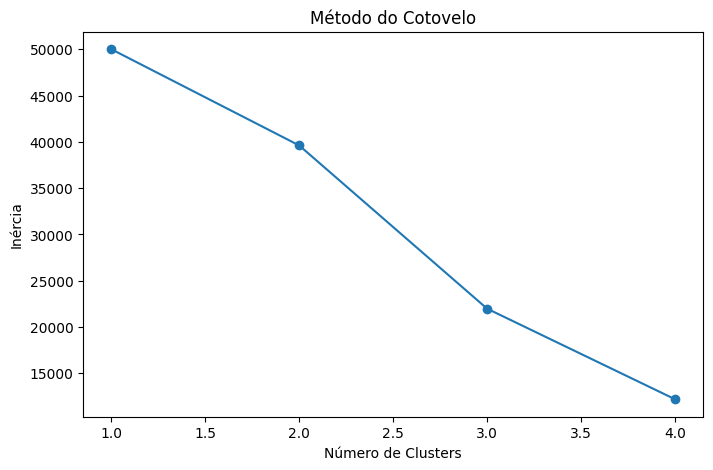

Pontuação de Silhueta Média: 0.5342355405458318


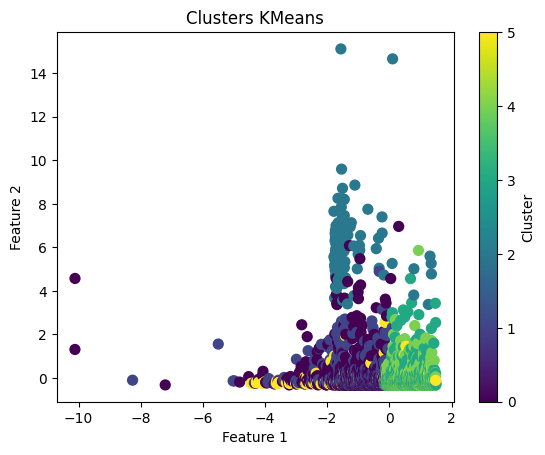

In [16]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Supondo que df_reduced é seu DataFrame PySpark
# Convertendo DataFrame PySpark para Pandas
df_pandas = df_reduced.toPandas()

# Substituir NaN por zero em todas as colunas
df_pandas = df_pandas.fillna(0)

# Separar features
X = df_pandas.drop(columns=['Destinos'])

# Converter colunas categóricas em variáveis dummy (one-hot encoding)
X = pd.get_dummies(X, columns=['Viagem_Urgente','Situacao',], drop_first=True)

# Normalizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determinar o número ideal de clusters usando o método do cotovelo
inertia = []
k_range = range(1, 5)  # Testar de 1 a 10 clusters
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plotar o gráfico do cotovelo
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo')
plt.show()

# Escolher o número de clusters ideal (baseado no gráfico)
n_clusters = 6  # Substitua pelo número ideal de clusters encontrado

# Ajustar o modelo KMeans com o número ideal de clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Adicionar os rótulos dos clusters ao DataFrame original
df_pandas['Cluster'] = clusters

# Avaliar a qualidade da clusterização
silhouette_avg = silhouette_score(X_scaled, clusters)
print(f'Pontuação de Silhueta Média: {silhouette_avg}')

# Visualizar os clusters (se possível)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis', s=50)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Clusters KMeans')
plt.colorbar(label='Cluster')
plt.show()

df_pandas.to_csv('clusters_output.csv', index=False)
